# Malware Names

Dealing with malware names...

Starting by filtering only the selected vendors, then understanding the unique number of names per vendor.

In [1]:
from IPython.display import display
from leven import levenshtein
import pandas as pd
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
import re
import itertools
import networkx as nx

data_folder = 'data/'
vendors_file = data_folder + 'vendors.csv.gz'
reports_file = data_folder + 'reports.csv.gz'
vendors_selected_file = data_folder + 'vendors_selected.csv.gz'
vendors_selected_filtered_file = data_folder + 'vendors_selected_filtered.csv.gz'
selected_vendors = ["Rising", "NANO-Antivirus", "Microsoft", "VBA32",
                    "TrendMicro", "Comodo", "AhnLab-V3", "Panda",
                    "Malwarebytes", "K7GW", "K7AntiVirus", "Symantec",
                    "MicroWorld-eScan", "F-Secure", "Ikarus", "DrWeb",
                    "Emsisoft", "Fortinet", "TrendMicro-HouseCall", "Avast",
                    "BitDefender", "AVG", "Kaspersky", "GData", "VIPRE",
                    "Sophos", "McAfee", "McAfee-GW-Edition", "ESET-NOD32"]

In [2]:
# Filter down vendors
# vendors = pd.read_csv(vendors_file, dtype=str)
# vendors = vendors.set_index('link')
# vendors = vendors[selected_vendors]
# vendors.to_csv(vendors_selected_file, compression='gzip')
vendors = pd.read_csv(vendors_selected_file, dtype=str)
vendors = vendors.set_index('link')
vendors.replace('Clean', np.nan, inplace=True)

In [3]:
unique_names = dict()
names_count = dict()
for vendor in vendors:
    unique_names[vendor] = vendors[vendor].dropna().unique()
    names_count[vendor] = len(vendors[vendor].dropna().unique())
    
names_count = pd.Series(names_count)

Graph showing the unique number of names per vendor:

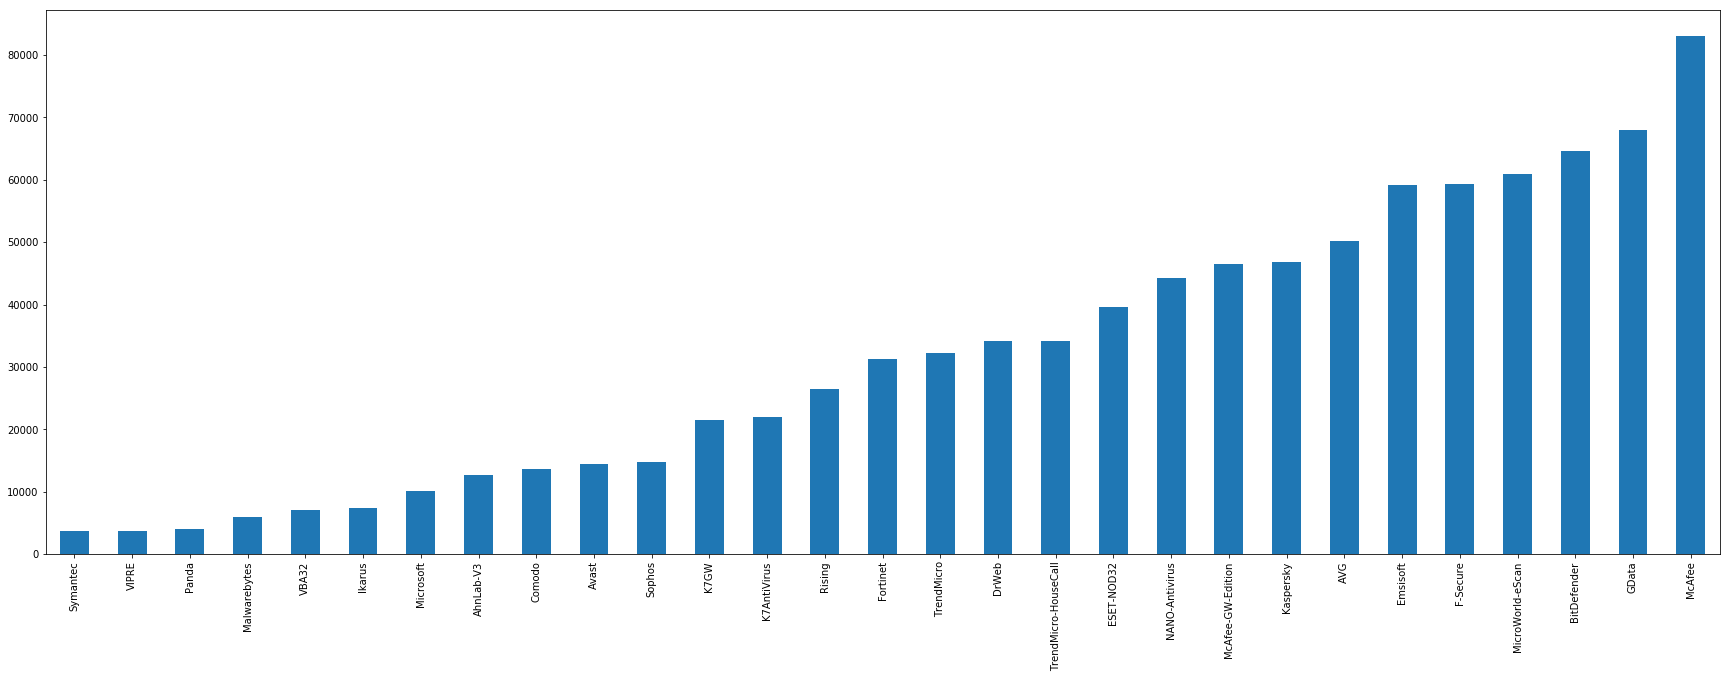

In [4]:
names_count.sort_values().plot.bar(figsize=((30, 10)))
plt.show()

## Understanding names

We want to split the malware into various levels and classes.

The highest level should be the propagation type: Virus, Worm, Trojan.

Bellow propagation type comes malware purpose and/or family.

### First Filterting

An inicial idea is to remove keywords below a given threshold, < 2 chars long. Keywords with 2 chars may still be relevant, like 'PE', 'BD', etc.

From len 2 strings, remove those with numbers. From all other, remove those that are hex values.

In [5]:
regex = re.compile(r'\W')
# Remove pairs that contain at least a number
regex2= re.compile(r'^\S\d|\d\S$')
# Remove hex values
regex3= re.compile(r'^[A-Fa-f0-9]{3,}$')

unique_keywords = dict()
filtered_names = dict()

for vendor in unique_names.keys():
    unique_keywords[vendor] = list()
    filtered_names[vendor] = set()
    for name in unique_names[vendor]:
        name = regex.split(name)
        unique_keywords[vendor] += name
        name = list(filter(lambda x: len(x) > 1 and not regex2.search(x) and not regex3.search(x), name))
        filtered_names[vendor].update(['.'.join(name)])

In [6]:
before = 0
after = 0
display('Filtered names:')
for vendor in filtered_names.keys():
    before += len(unique_names[vendor])
    after += len(filtered_names[vendor])
    # display('{} {}/{}'.format(vendor, len(filtered_names[vendor]), len(unique_names[vendor])))
display('Total: {}/{}'.format(after, before))

'Filtered names:'

'Total: 415519/921603'

Graph showing the number of filtered names per vendor, followed by graph with comparison of both

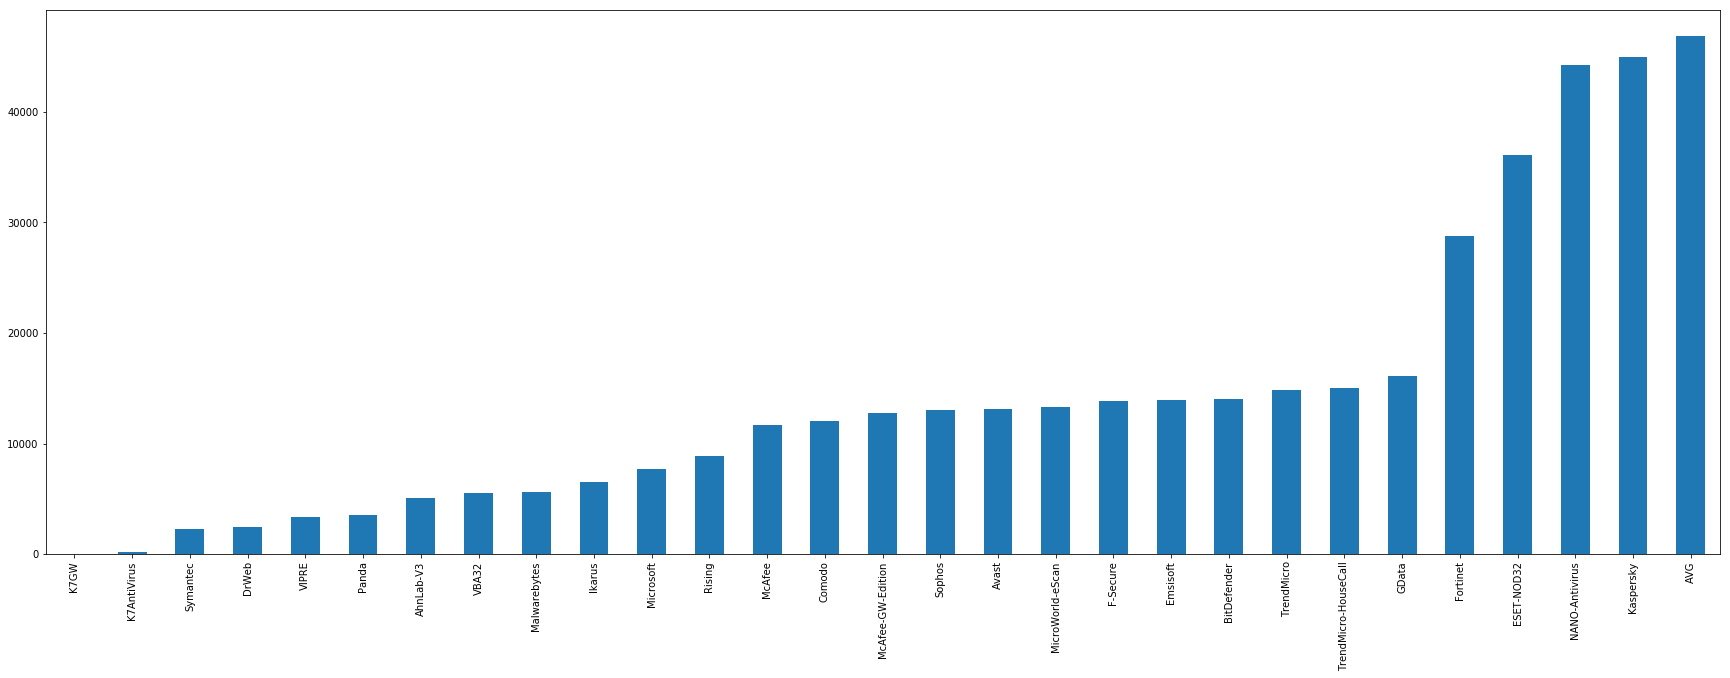

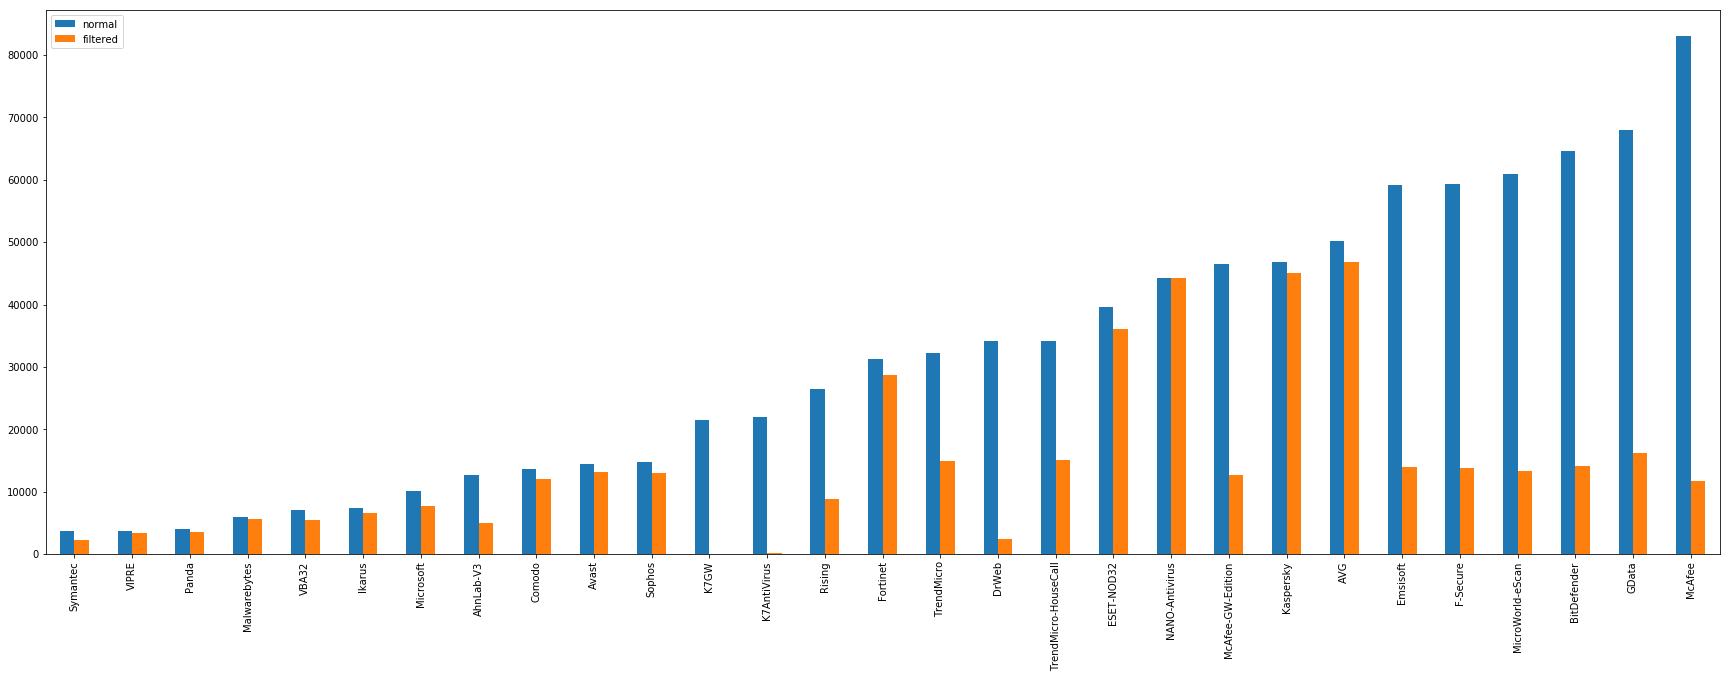

In [7]:
filtered_count = dict()
for vendor in filtered_names.keys():
    filtered_count[vendor] = len(filtered_names[vendor])
filtered_count = pd.Series(filtered_count)
filtered_count.sort_values().plot.bar(figsize=((30, 10)))
    
names_count_df = pd.DataFrame(names_count)
names_count_df[1] = filtered_count
names_count_df.columns = ['normal', 'filtered']
names_count_df.sort_values(by='normal').plot.bar(figsize=((30, 10)))
plt.show()

Apply the filter to the vendors DataFrame

In [8]:
def filter_func(name):
    if name is np.nan:
        return np.nan
    name = regex.split(name)
    name = list(filter(lambda x: len(x) > 1 and not regex2.search(x) and not regex3.search(x), name))
    return '.'.join(name)

# vendors_filtered = vendors.applymap(filter_func)
# vendors_filtered.to_csv(vendors_selected_filtered_file, compression='gzip')
vendors_filtered = pd.read_csv(vendors_selected_filtered_file, dtype='str')
vendors_filtered = vendors_filtered.set_index('link')

Build the name graph

In [9]:
subset = vendors_filtered[:100]
subset.is_copy = False
display(subset)

,Rising,NANO-Antivirus,Microsoft,VBA32,TrendMicro,Comodo,AhnLab-V3,Panda,Malwarebytes,K7GW,...,Avast,BitDefender,AVG,Kaspersky,GData,VIPRE,Sophos,McAfee,McAfee-GW-Edition,ESET-NOD32
link,,,,,,,,,,,,,,,,,,,,,
MDRlOGFlOTRjMzNjNGJhNmEwMWQ0MWFiMDYzYmJhNmI,PE.Backdoor.Undef,Trojan.Inject.sang,Trojan.Pugeju,BScope.Trojan.Kidalo,TROJ_GEN,TrojWare.Trojan.Agent.Gen,NaN,Trj.Downloader.TCN,NaN,Riskware,...,Obfuscated.EHL.Trj,Gen.ExplorerHijack.bmHfaGxumE,Small.BO,HEUR.Trojan.Invader,Gen.ExplorerHijack.bmHfaGxumE,Trojan.Generic.BT,Mal.Behav,generic.bg.exq,generic.bg.exq,variant.of.Obfuscated.NAX
YzE2YTA3ZmNkOTIyNDkyMTk1YmY5ZTEyNTkzZTc5ODI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Suspicious.file,Rootkit.0Access,NaN,...,NaN,Gen.Variant.Symmi,NaN,Packed.Katusha,Gen.Variant.Symmi,NaN,NaN,NaN,NaN,variant.of.Kryptik.BKBB
MjEwYmY3OGExMGMyNGM0Y2JhN2NlNjg2ZjY1MzAxMTI,NaN,Trojan.FrauDrop.cwxrdl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,MSIL.GenMalicious.GG.Trj,NaN,NaN,NaN,NaN,NaN,Troj.MSIL.BHT,NaN,BehavesLike.Suspect.vc,variant.of.MSIL.Injector.CUZ
YzViZWZlMWJhNjU5NDIyMWFjNWU1NDY2OWRmYTM1ZWM,PE.Trojan.Generic,Trojan.XDR.czpdjp,VirTool.Vbinder,SScope.Trojan.Zbot.gen,NaN,NaN,NaN,Trj.Chgt,NaN,Trojan,...,Malware.gen,Gen.Trojan.Heur.zuZ.XwR.JWii,BackDoor.WJC,HEUR.Trojan.Generic,Gen.Trojan.Heur.zuZ.XwR.JWii,Detect.Trojan.Small.nmm,Mal.Generic,Artemis,NaN,TrojanDropper.Small.NMM
MGM2OTY4ZGRhM2U0NGFjYWFmOGJkODk2ODU1NzI1Y2I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YjA2YzRiODk5YmZkNDY4NTliMjI4ZDFmMGUxYWVjYWY,NaN,Trojan.Injector.dobjgo,NaN,NaN,TROJ_GEN,NaN,NaN,Trj.Genetic.gen,NaN,Unwanted.Program,...,Malware.gen,Trojan.Generic,Crypt3.BWEF,Trojan.Dropper.Injector.lezv,Trojan.Generic,Trojan.Generic.BT,Mal.Generic,RDN.Generic.hra.ce,RDN.Generic.hra.ce,variant.of.Kryptik.CWCW
M2Y4MTg2YjZmODVhNGUyZGJhZTQ4YmZkZjRjZGJmNzI,NaN,NaN,NaN,suspected.of.Trojan.Downloader.gen,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Gen.Variant.Symmi,NaN,HEUR.Trojan.Generic,Gen.Variant.Symmi,NaN,NaN,NaN,NaN,variant.of.TrojanDownloader.Banload.URO
Y2Y4MTJjODk2N2Y3NGI2ODgzYTZkNWZjMDViYzQzODQ,NaN,Trojan.Click2.dfnbfk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Malware.gen,NaN,OMC,NaN,NaN,NaN,NaN,Artemis,BehavesLike.Rontokbro.tc,NaN
YmU1YzRhYzZhZDkwNDdmZjhiY2NjOTAyNWMxOWZjMGQ,PE.Trojan.Spammer.aew,Trojan.Agent.tjzy,PWS.Fignotok,Trojan.Dropper.Resgen,BKDR_BIFROSE.SMN,TrojWare.PSW.Agent.SZX,Trojan.Agent,Trj.Downloader.MDW,Trojan.PWS,Trojan,...,Spyware.gen.Spy,Trojan.Agent.AOLF,Agent4.AJSR,Trojan.Agent.cccr,Trojan.Agent.AOLF,Trojan.Agent.cccr,Troj.Spy.ED,Generic.Dropper.ny,Heuristic.LooksLike.Suspicious,PSW.Agent.NLY


In [10]:
# Create a list of names to replace their ocurrences in the table by the index in the list
names = set()

for vendor in subset:
    names.update(subset[vendor].dropna().unique())
names = list(names)

In [11]:
# Replace the names with their index
for name in names:
    subset.replace(name, names.index(name), inplace=True)

In [23]:
# TODO replace the names with an index, use it in the sparse matrix
# in the end, do the counting and replace the indexes with the actual names.

matrix = scipy.sparse.dok_matrix((len(names), len(names)))

for idx, sample in subset.iterrows():
    values = map(int, sample.dropna().values)
    for i, j in itertools.combinations(values, 2):
        matrix[i, j] += 1

In [24]:
#matrix = np.divide(matrix, np.max(matrix))

# display(matrix.todense())

# display(matrix.todense().max())

In [29]:
graph = nx.Graph()
# graph.add_nodes_from(names)
for line in range(len(names)):
    for col in range(len(names)):
        if matrix[line, col] >= 0:
            # graph.add_nodes_from([names[line], names[col]])
            graph.add_edge(names[line], names[col], weight=matrix[line, col])

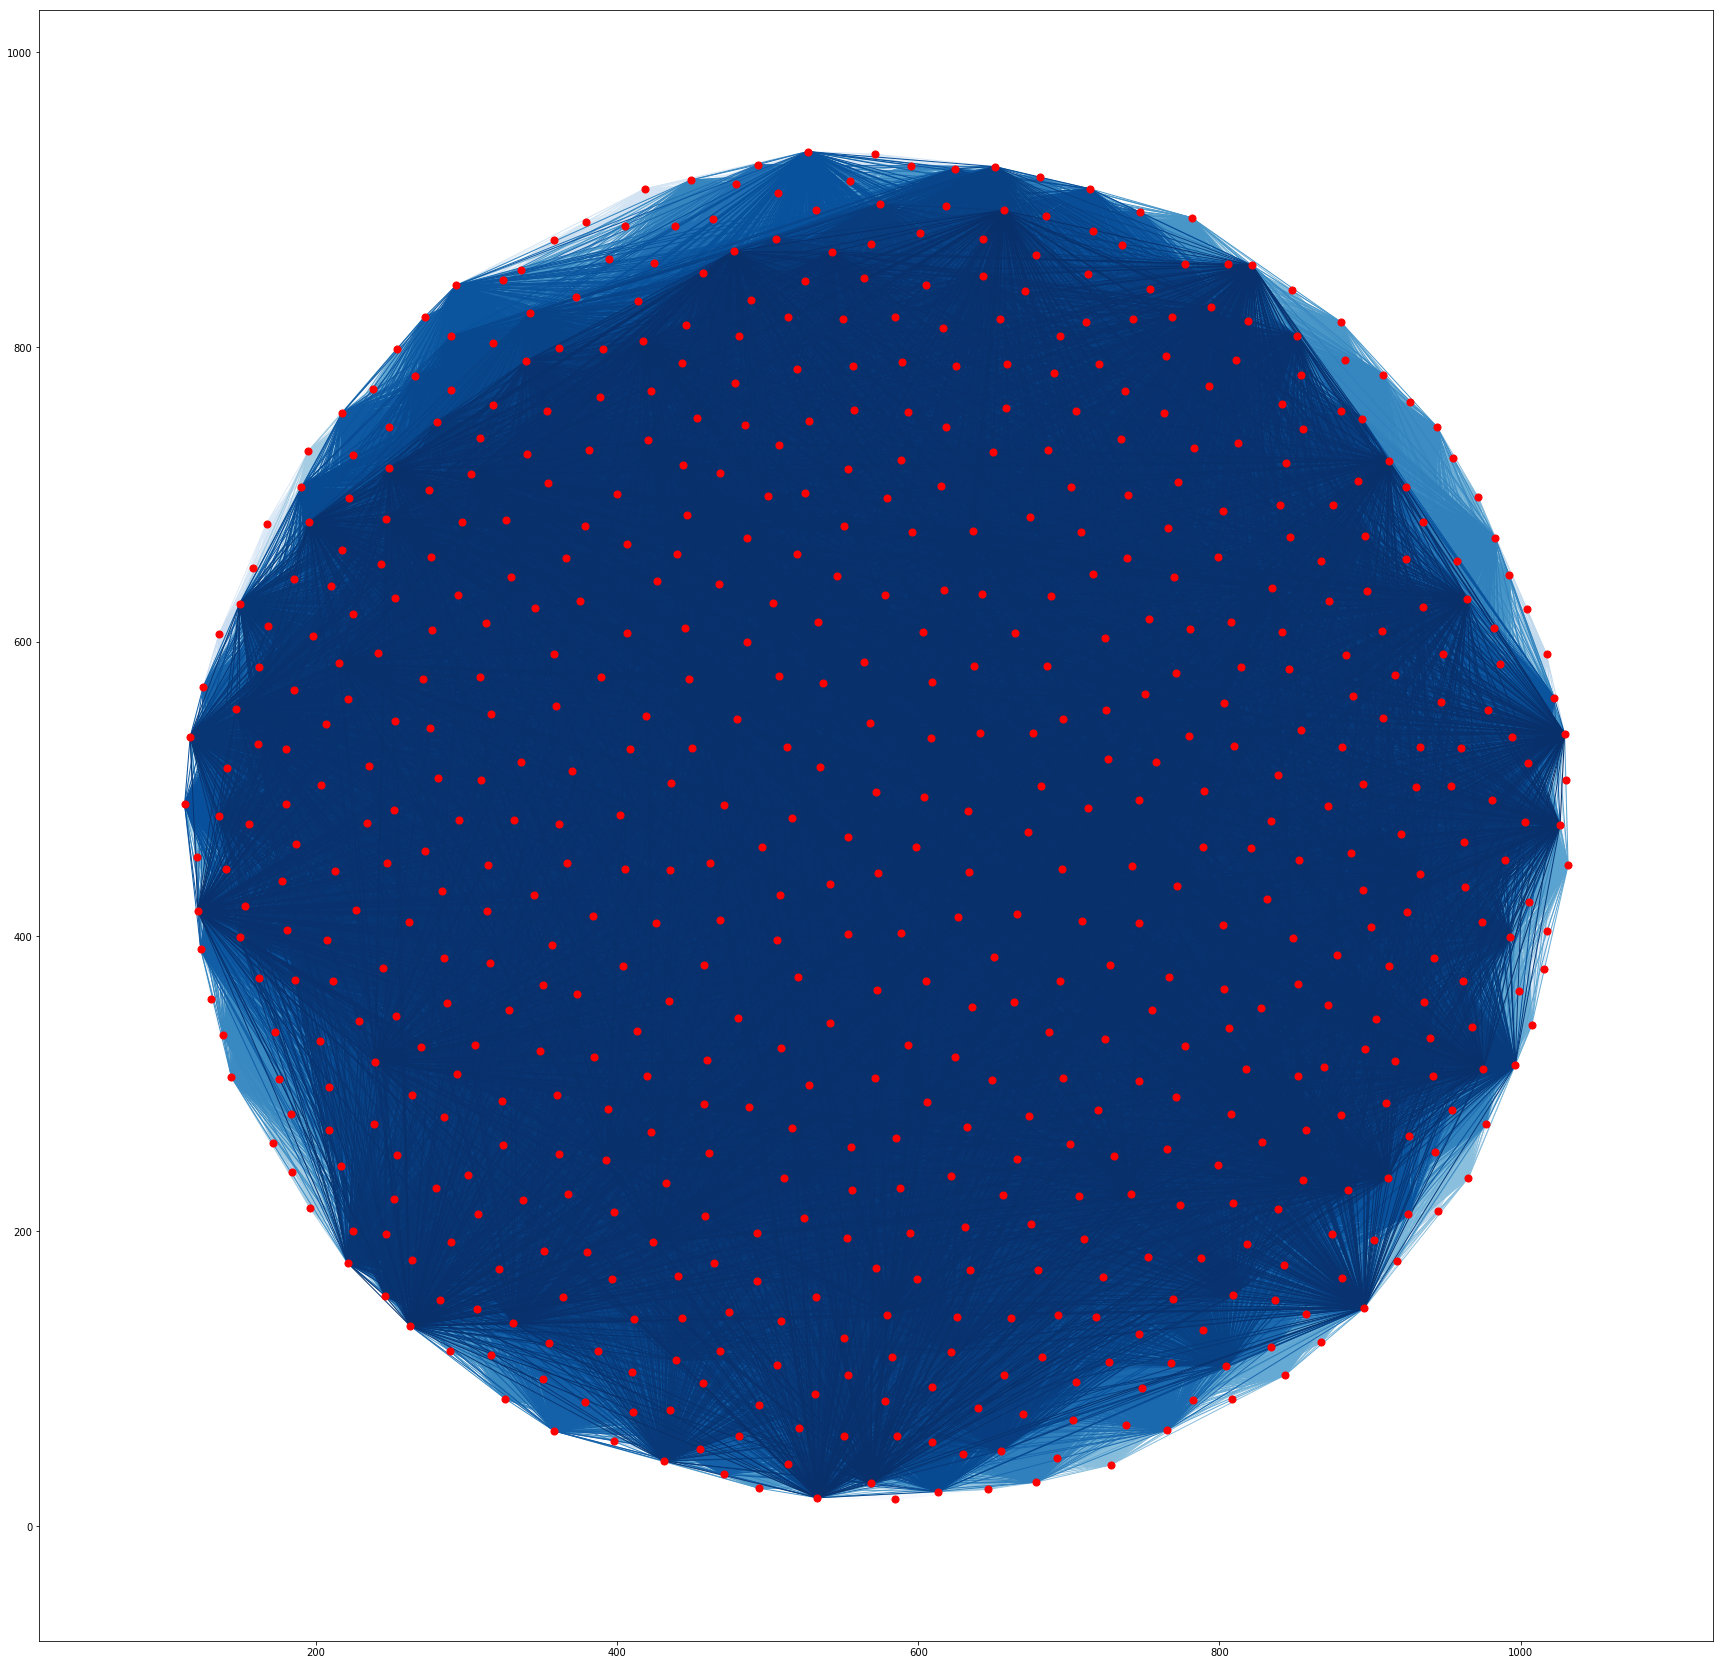

In [30]:
from networkx.drawing.nx_agraph import graphviz_layout
colors = range(len(graph.edges()))
pos = graphviz_layout(graph, prog='sfdp')
pos = graphviz_layout(graph, prog='twopi')
# pos = graphviz_layout(graph ,prog='neato')
plt.figure(figsize=(30,30))
nx.draw_networkx(graph, pos, with_labels=False, font_size=5, node_size=50, edge_cmap=plt.cm.Blues, edge_color=colors)
# plt.savefig('test.eps', format='eps', dpi=1000)
plt.show()